In [ ]:
import os
import requests
import json
from google.colab import drive
drive.mount("/content/drive/")

realNewsWebsites_path = os.path.join(DATASET_DIR, "realNewsWebsites.json") # 1368
with open(realNewsWebsites_path) as file:
    realNewsWebsites = json.load(file)

realbrsites_path = f"{DATASET_DIR}/realbrsites.txt" #73
with open(realbrsites_path) as file:
    realbrsites = file.readlines()

LEGITM_SITES = realNewsWebsites + realbrsites
len(LEGITM_SITES)

Mounted at /content/drive/


1441

# Setup and Imports



In [ ]:
import re
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

from google.colab import drive
drive.mount("/content/drive/")
DATASET_DIR = os.path.join("/content/drive/MyDrive/TCC/workspace/datasets")
RESULTS_DIR =  os.path.join("/content/drive/MyDrive/TCC/workspace/experiments/results")

fakebrcorpus_full = pd.read_csv(f"{DATASET_DIR}/Fakebr/full_text_fakebrcorpus.csv")
liar_full = pd.read_csv(f'{DATASET_DIR}/LIAR/liar_full.csv')

REGEX_EXPLANATION = r"(Explanation|Explicação):\s*\**(.*)"
REGEX_ANSWER_EN = r"\**(Answer)\**:\**\s*\[?(\d+)\]?"
REGEX_ANSWER_PT = r"\**(Resposta|Avaliação)\**:\**\s*\[?(\d+)\]?"
REGEX_0_EXCEPTION = r"N/A|0/1|[?]"
REGEX_1_EXCEPTION = r"1/1"
REGEX_ANSWER_EXCEPTION = r"(Answer|Resposta):"

def plot(confusion_matrix, title):
  disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=["Fake News", "True News"])
  disp.plot()
  plt.title(title)
  plt.show()


def evaluate_assistant_answer(true_labels, predicted_labels):
    y_true = list(true_labels['label'])
    y_pred = list(predicted_labels['label'])

    cm = confusion_matrix(y_true, y_pred, labels=[0,1], normalize='true')

    # TP = cm[0, 0]  # True Positives
    # FN = cm[0, 1]  # False Negatives
    # FP = cm[1, 0]  # False Positives
    # TN = cm[1, 1]  # True Negatives

    # # Accuracy: (TP + TN) / Total
    # accuracy = (TP + TN) / (TP + TN + FP + FN)

    # # Precision: TP / (TP + FP)
    # precision = TP / (TP + FP) if (TP + FP) != 0 else 0

    # # Recall: TP / (TP + FN)
    # recall = TP / (TP + FN) if (TP + FN) != 0 else 0

    # # F1-Score: 2 * (Precision * Recall) / (Precision + Recall)
    # f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    accuracy = accuracy_score(y_true, y_pred)

   # 0 = Fake news. Using pos_label=0, we're telling that the class of the interesse is 0 (fake news), then the "positive" values is Fake news
    precision_f = precision_score(y_true, y_pred, pos_label=0)
    recall_f = recall_score(y_true, y_pred, pos_label=0)
    f1_f = f1_score(y_true, y_pred, pos_label=0)

    precision_t = precision_score(y_true, y_pred, pos_label=1)
    recall_t = recall_score(y_true, y_pred, pos_label=1)
    f1_t = f1_score(y_true, y_pred, pos_label=1)

    f1_micro = f1_score(y_true, y_pred, average='micro')
    f1_macro = f1_score(y_true, y_pred, average='macro')

    metrics = {
        # "method": predicted_labels["method"].loc[0],
        "accuracy": round(accuracy,4),
        "f1_macro": round(f1_macro,4),
        "f1_micro": round(f1_micro,4),
        "f1_t": round(f1_t,4),
        "precision_t": round(precision_t,4),
        "recall_t": round(recall_t,4),
        "f1_f": round(f1_f,4),
        "precision_f": round(precision_f,4),
        "recall_f": round(recall_f,4)
    }

    return cm, metrics

def get_results_df(outputs):
    results_df = pd.DataFrame(columns=["label", "explanation", "output"])
    outputs = list(outputs["output"])
    for i, out in enumerate(outputs):
      explanation_out = re.search(REGEX_EXPLANATION, out)
      explanation =  explanation_out.group(2) if explanation_out else "Model couln't give a explanation or answer."

      answer_out = re.search(REGEX_ANSWER_EN, out) or re.search(REGEX_ANSWER_PT, out)
      if answer_out:
        answer = int(answer_out.group(2))
      elif re.search(REGEX_0_EXCEPTION, out):
        answer = 0
      elif re.search(REGEX_1_EXCEPTION, out):
        answer = 1
      elif not re.search(REGEX_ANSWER_EXCEPTION, out):
        answer = 0
      else:
          raise Exception(f"ANSWER PROBLEM FOUND IN CLAIM {i+2}:\n {out} ")


      new_row = [answer, explanation, out]
      results_df.loc[len(results_df)] = new_row

    return results_df


In [ ]:
!pip install unsloth==2025.1.1
!pip install pyarrow==17.0.0
!pip install transformers==4.47.1
!pip install accelerate==1.2.1
!pip install torch==2.5.1
!pip install bitsandbytes==0.45.0
!pip install trl==0.13.0
!pip install datasets==3.2.0

!python --version

# FakeBR

In [ ]:
import numpy as np

tokenizer.truncation_side = "left"
tokenizer.pad_token = tokenizer.eos_token
lengths = [len(tokenizer(text, truncation=False)["input_ids"]) for text in fakebr_corpus_df["prompt"]]
print(f'''Max: {max(lengths)},
Mean: {sum(lengths)/len(lengths)},
90th Percentile: {np.percentile(lengths, 90)}
70th Percentile: {np.percentile(lengths, 70)}''')

Max: 8035,
Mean: 755.7084722222222,
90th Percentile: 1740.2000000000007
70th Percentile: 928.2999999999993


In [ ]:
fakebr_corpus_df["tokenized"] = lengths
analysis_br_0_512 = fakebr_corpus_df[fakebr_corpus_df["tokenized"].between(0,512)]
analysis_br_0_1024 = fakebr_corpus_df[fakebr_corpus_df["tokenized"].between(0,1024)]
analysis_br_0_2048 = fakebr_corpus_df[fakebr_corpus_df["tokenized"].between(0,2048)]

In [ ]:
print("Between 0 and 512 tokens")
print(f'''Falsas: {len(analysis_br_0_512[analysis_br_0_512['label']==0])}
Verdadeiras: {len(analysis_br_0_512[analysis_br_0_512['label']==1])}
Total: {len(analysis_br_0_512)}''')

print("\nBetween 0 and 1024 tokens")
print(f'''Falsas: {len(analysis_br_0_1024[analysis_br_0_1024['label']==0])}
Verdadeiras: {len(analysis_br_0_1024[analysis_br_0_1024['label']==1])}
Total: {len(analysis_br_0_1024)}''')

print("\nBetween 0 and 2048 tokens")
print(f'''Falsas: {len(analysis_br_0_2048[analysis_br_0_2048['label']==0])}
Verdadeiras: {len(analysis_br_0_2048[analysis_br_0_2048['label']==1])}
Total: {len(analysis_br_0_2048)}''')

Between 0 and 512 tokens
Falsas: 3454
Verdadeiras: 293
Total: 3747

Between 0 and 1024 tokens
Falsas: 3588
Verdadeiras: 1727
Total: 5315

Between 0 and 2048 tokens
Falsas: 3598
Verdadeiras: 3116
Total: 6714


# LIAR

In [ ]:
import numpy as np

tokenizer.truncation_side = "left"
tokenizer.pad_token = tokenizer.eos_token
lengths = [len(tokenizer(text, truncation=False)["input_ids"]) for text in liar_train_v2["text"]]
print(f'''Max: {max(lengths)},
Mean: {sum(lengths)/len(lengths)},
90th Percentile: {np.percentile(lengths, 90)}
70th Percentile: {np.percentile(lengths, 70)}''')

Max: 566,
Mean: 22.772269136475074,
90th Percentile: 34.0
70th Percentile: 26.0


In [ ]:
liar_train_v2["tokenized"] = lengths
analysis_liart_0_512 = liar_train_v2[liar_train_v2["tokenized"].between(0,512)]
analysis_liart_0_1024 = liar_train_v2[liar_train_v2["tokenized"].between(0,1024)]
analysis_liart_0_2048 = liar_train_v2[liar_train_v2["tokenized"].between(0,2048)]

In [ ]:
print("Between 0 and 512 tokens")
print(f'''Falsas: {len(analysis_liart_0_512[analysis_liart_0_512['label']==0])}
Verdadeiras: {len(analysis_liart_0_512[analysis_liart_0_512['label']==1])}
Total: {len(analysis_liart_0_512)}''')

print("\nBetween 0 and 1024 tokens")
print(f'''Falsas: {len(analysis_liart_0_1024[analysis_liart_0_1024['label']==0])}
Verdadeiras: {len(analysis_liart_0_1024[analysis_liart_0_1024['label']==1])}
Total: {len(analysis_liart_0_1024)}''')

print("\nBetween 0 and 2048 tokens")
print(f'''Falsas: {len(analysis_liart_0_2048[analysis_liart_0_2048['label']==0])}
Verdadeiras: {len(analysis_liart_0_2048[analysis_liart_0_2048['label']==1])}
Total: {len(analysis_liart_0_2048)}''')

Between 0 and 512 tokens
Falsas: 1994
Verdadeiras: 1676
Total: 3670

Between 0 and 1024 tokens
Falsas: 1995
Verdadeiras: 1676
Total: 3671

Between 0 and 2048 tokens
Falsas: 1995
Verdadeiras: 1676
Total: 3671


In [ ]:
new_df = liar_train_v2[liar_train_v2["tokenized"] > 2048]
len(new_df[new_df['label']==0]), len(new_df[new_df['label']==1]), len(new_df)

(0, 0, 0)

# Benchmark results (English)

In [ ]:
enUS_LLaMA_full = get_results_df(pd.read_csv(os.path.join(RESULTS_DIR, "raw_enUS_LLaMA_full.csv"), index_col=False))
enUS_Qwen_full = get_results_df(pd.read_csv(os.path.join(RESULTS_DIR, "raw_enUS_Qwen_full.csv"), index_col=False))
enUS_Ministral_full = get_results_df(pd.read_csv(os.path.join(RESULTS_DIR, "raw_enUS_Ministral_full.csv"), index_col=False))
enUS_STEEL_HyDE_full = pd.read_csv(os.path.join(RESULTS_DIR, "raw_enUS_STEEL_HyDE_full.csv"), index_col=False)
enUS_STEEL_HyDE_full['label'] = enUS_STEEL_HyDE_full['label'].replace({2:0})

enUS_LLaMA_full["method"] = "Llama-3.1-8B-Instruct"
enUS_Qwen_full["method"] = "Qwen2.5-7B-Instruct "
enUS_Ministral_full["method"] = "Ministral-8B-Instruct-2410"
enUS_STEEL_HyDE_full["method"] = "STEEL_HyDE"


enUS_LLaMA_full = enUS_LLaMA_full[:len(enUS_LLaMA_full)//2]
enUS_Qwen_full = enUS_Qwen_full[:len(enUS_Qwen_full)//2]
enUS_Ministral_full = enUS_Ministral_full[:len(enUS_Ministral_full)//2]
enUS_STEEL_HyDE_full = enUS_STEEL_HyDE_full[:len(enUS_STEEL_HyDE_full)//2]

In [ ]:
enUS_metrics = []
enUS_cm = []
for df in [enUS_LLaMA_full, enUS_Qwen_full, enUS_Ministral_full, enUS_STEEL_HyDE_full]:
  cm, metrics = evaluate_assistant_answer(liar_full[:len(liar_full)//2], df)
  enUS_cm.append(cm)
  enUS_metrics.append(metrics)

metrics_df = pd.DataFrame(enUS_metrics)

In [ ]:
metrics_df.to_csv(os.path.join(os.getcwd(), "enUS_metrics.csv"))

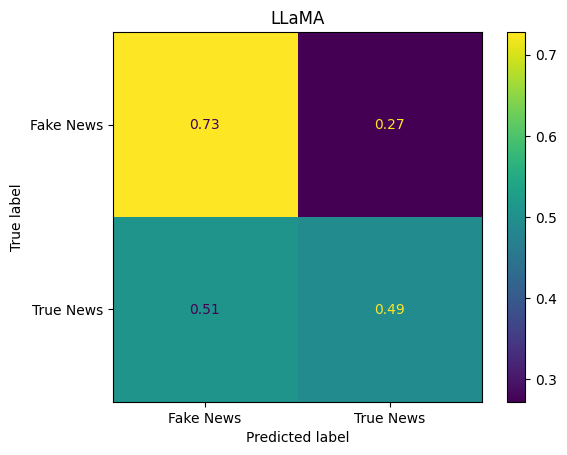

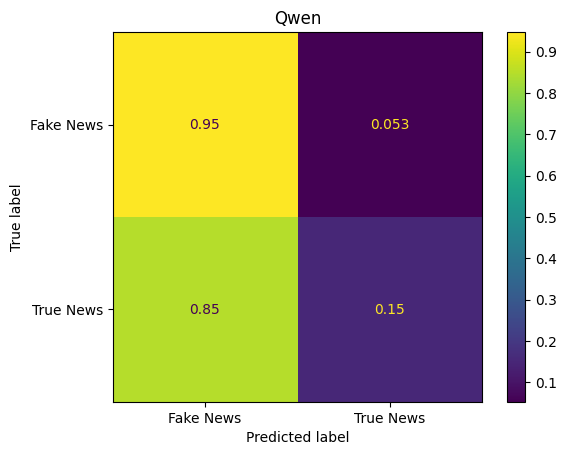

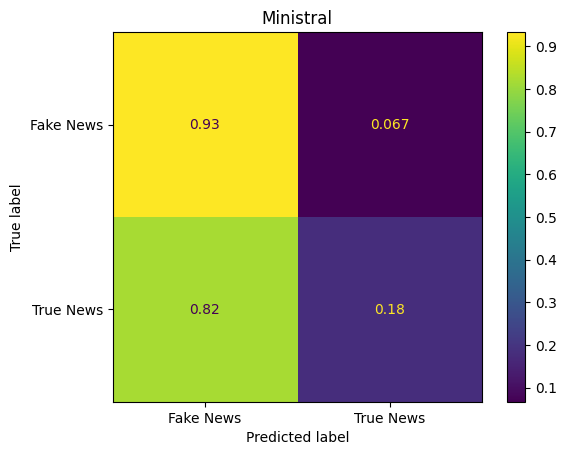

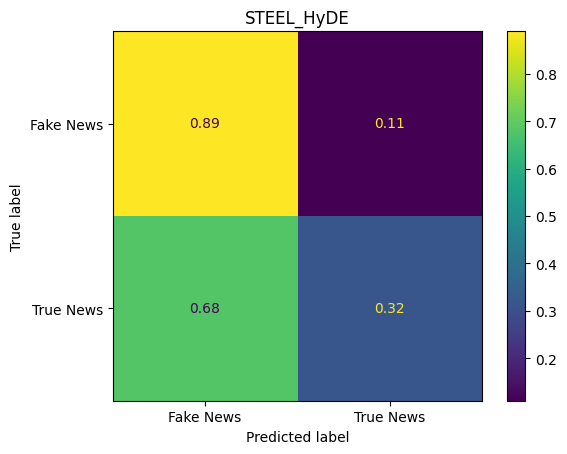

(None, None, None, None)

In [ ]:
plot(enUS_cm[0], "LLaMA"), plot(enUS_cm[1], "Qwen"), plot(enUS_cm[2], "Ministral"), plot(enUS_cm[3], "STEEL_HyDE")

# Benchmark results (Brazilian)

In [ ]:
ptBR_LLaMA_full = get_results_df(pd.read_csv(os.path.join(RESULTS_DIR, "raw_ptBR_LLaMA_full.csv"), index_col=False))
ptBR_Qwen_full = get_results_df(pd.read_csv(os.path.join(RESULTS_DIR, "raw_ptBR_Qwen_full.csv"), index_col=False))
ptBR_Ministral_full = get_results_df(pd.read_csv(os.path.join(RESULTS_DIR, "raw_ptBR_Ministral_full.csv"), index_col=False))
ptBR_STEEL_HyDE_full = pd.read_csv(os.path.join(RESULTS_DIR, "raw_ptBR_STEEL_HyDE_full.csv"), index_col=False)
ptBR_STEEL_HyDE_full['label'] = ptBR_STEEL_HyDE_full['label'].replace({2:0})

ptBR_LLaMA_full["method"] = "Llama-3.1-8B-Instruct"
ptBR_Qwen_full["method"] = "Qwen2.5-7B-Instruct "
ptBR_Ministral_full["method"] = "Ministral-8B-Instruct-2410"
ptBR_STEEL_HyDE_full["method"] = "STEEL_HyDE"

In [ ]:
ptBR_metrics = []
ptBR_cm = []
for df in [ptBR_LLaMA_full, ptBR_Qwen_full, ptBR_Ministral_full, ptBR_STEEL_HyDE_full]:
  cm, metrics = evaluate_assistant_answer(fakebrcorpus_full, df)
  ptBR_cm.append(cm)
  ptBR_metrics.append(metrics)

metrics_df = pd.DataFrame(ptBR_metrics)

In [ ]:
metrics_df.to_csv(os.path.join(os.getcwd(), "ptBR_metrics.csv"))

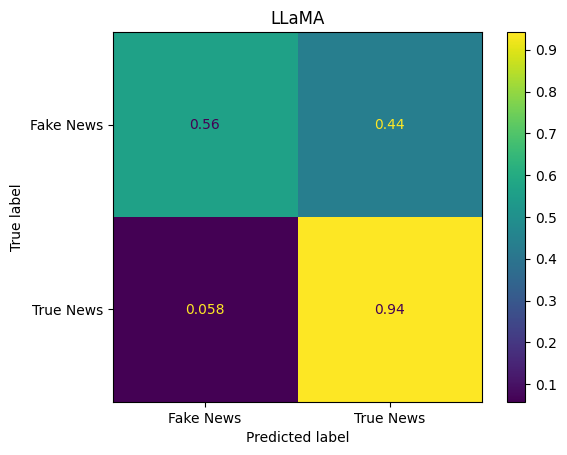

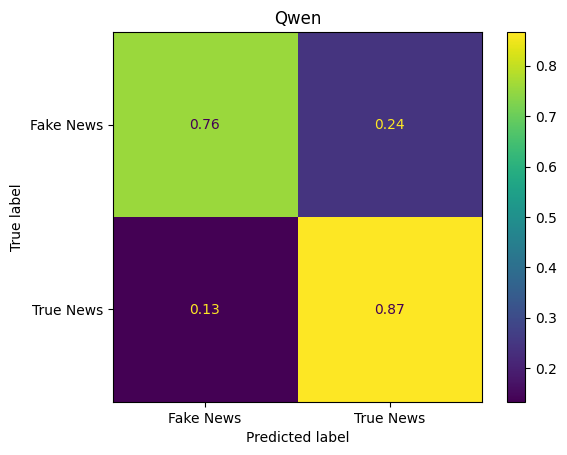

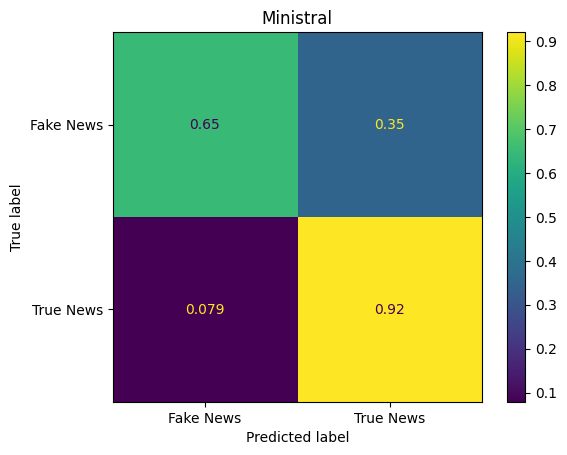

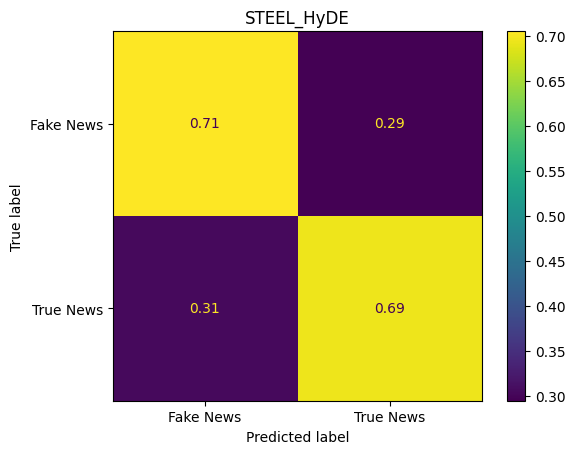

(None, None, None, None)

In [ ]:
plot(ptBR_cm[0], "LLaMA"), plot(ptBR_cm[1], "Qwen"), plot(ptBR_cm[2], "Ministral"), plot(ptBR_cm[3], "STEEL_HyDE")

In [ ]:
without_NEI = ptBR_STEEL_HyDE_full[ptBR_STEEL_HyDE_full['label'] != 2]
filtered = fakebrcorpus_full[fakebrcorpus_full.index.isin(without_NEI.index)]

cm, metrics = evaluate_assistant_answer(filtered, without_NEI)

In [ ]:
cm, metrics

(array([[0.56922452, 0.43077548],
        [0.15162822, 0.84837178]]),
 {'accuracy': 0.7213,
  'f1_macro': 0.7093,
  'f1_micro': 0.7213,
  'f1_t': 0.7684,
  'precision_t': 0.7021,
  'recall_t': 0.8484,
  'f1_f': 0.6503,
  'precision_f': 0.7582,
  'recall_f': 0.5692})

## NEI analyses

In [ ]:
ptBR_STEEL_HyDE_full = pd.read_csv(os.path.join(RESULTS_DIR, "raw_ptBR_STEEL_HyDE_full.csv"), index_col=False)

NEI = ptBR_STEEL_HyDE_full[ptBR_STEEL_HyDE_full['label'] == 2]
false = ptBR_STEEL_HyDE_full[ptBR_STEEL_HyDE_full['label'] == 0]
true = ptBR_STEEL_HyDE_full[ptBR_STEEL_HyDE_full['label'] == 1]

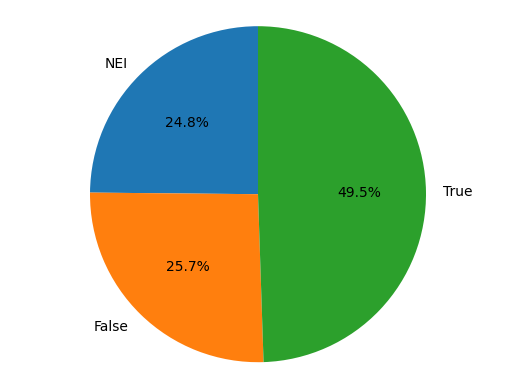

In [ ]:
import matplotlib.pyplot as plt

labels = ["NEI", "False", "True"]
sizes = [len(NEI), len(false), len(true)]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, startangle=90, autopct='%1.1f%%')
ax.axis('equal')

plt.show()

In [ ]:
enUS_STEEL_HyDE_full = pd.read_csv(os.path.join(RESULTS_DIR, "raw_enUS_STEEL_HyDE_full.csv"), index_col=False)

NEI = enUS_STEEL_HyDE_full[enUS_STEEL_HyDE_full['label'] == 2]
false = enUS_STEEL_HyDE_full[enUS_STEEL_HyDE_full['label'] == 0]
true = enUS_STEEL_HyDE_full[enUS_STEEL_HyDE_full['label'] == 1]

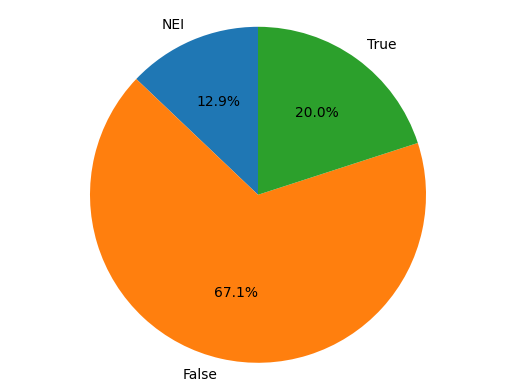

In [ ]:
import matplotlib.pyplot as plt

labels = ["NEI", "False", "True"]
sizes = [len(NEI), len(false), len(true)]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, startangle=90, autopct='%1.1f%%')
ax.axis('equal')

plt.show()